In [1]:
import nltk
import pandas as pd
import numpy as np
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer
stop_words = stopwords.words('english')
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
words = set(nltk.corpus.words.words())
# from stop import stop_words
from textblob import TextBlob
import requests
from pycomp.viz.insights import *
from collections import Counter
import gensim
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from zeugma.embeddings import EmbeddingTransformer

import warnings
warnings.filterwarnings('ignore')

In [2]:
text = requests.get('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/train_text.txt').text
label = requests.get('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/train_labels.txt').text
val_text = requests.get('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/val_text.txt').text
val_label = requests.get('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/val_labels.txt').text
text_test = requests.get('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/test_text.txt').text
label_test = requests.get('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/test_labels.txt').text

In [3]:
def process(label,text):
    
    tag = []
    for sent in label.split("\n"):
        try:
            tag.append(int(sent))
        except ValueError:
            pass

    tweet = []
    for text in text.split('\n'):
        try:
            tweet.append(text)
        except ValueError:
            pass
        
    data = {'tweet':tweet[:-1],'tag':tag}
    df = pd.DataFrame(data)
    df['class'] = df.tag.apply(lambda x:'not-hate' if x==0 else 'hate')
    return df

In [4]:
df = process(label,text)
df_val = process(val_label,val_text)
df_test = process(label_test,text_test)

In [5]:
df

,tweet,tag,class
0,@user nice new signage. Are you not concerned ...,0,not-hate
1,A woman who you fucked multiple times saying y...,1,hate
2,@user @user real talk do you have eyes or were...,1,hate
3,your girlfriend lookin at me like a groupie in...,1,hate
4,Hysterical woman like @user,0,not-hate
...,...,...,...
8995,Oooohhhh bitch didn't even listen to the dead ...,0,not-hate
8996,@user Good Luck @user More Americans #WalkAway...,0,not-hate
8997,Bitch you can't keep up so stop trying,1,hate
8998,@user @user @user @user @user @user Japan is a...,0,not-hate


In [6]:
def cleaner(tweet):
    
    tweet = re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", tweet)
    tweet = tweet.lower()
    tweet = tweet.split()
#     tweet = ([word for word in tweet if not word in stop_words])
#     tweet = " ".join([lemmatizer.lemmatize(word) for word in tweet])
    tweet = " ".join([stemmer.stem(word) for word in tweet])
    
    tweet = tweet.replace("user", "")


    return  tweet

In [7]:
def cleanup(df):
    
    train_cleaned = df['tweet'].apply(cleaner)
    df['tweet'] = train_cleaned.apply(lambda x: ' '.join([w for w in x.split() if len(w)>1]))
    
    return df 

In [8]:
train_cleaned = cleanup(df)
val_cleaned = cleanup(df_val)
test_cleaned = cleanup(df_test)

In [9]:
train_cleaned

,tweet,tag,class
0,nice new signag are you not concern by beatlem...,0,not-hate
1,woman who you fuck multipl time say yo dick sm...,1,hate
2,real talk do you have eye or were they goug ou...,1,hate
3,your girlfriend lookin at me like groupi in th...,1,hate
4,hyster woman like,0,not-hate
...,...,...,...
8995,oooohhhh bitch didnt even listen to the dead k...,0,not-hate
8996,good luck more american walkawayfromdemocrat w...,0,not-hate
8997,bitch you cant keep up so stop tri,1,hate
8998,japan is alway oper under the premis that mass...,0,not-hate


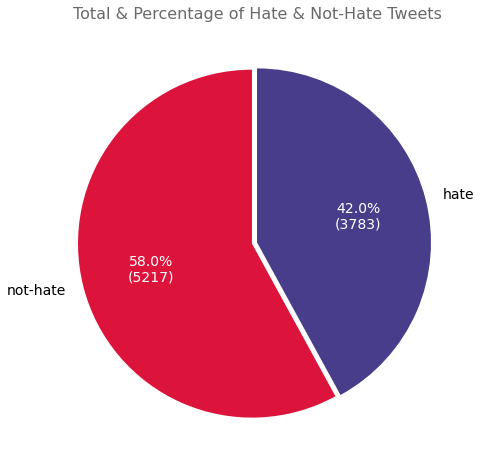

In [10]:
plot_pie_chart(df=df, col='class', colors=['crimson', 'darkslateblue', 'darkgrey'],
               explode=(0.03, 0),
               title="Total & Percentage of Hate & Not-Hate Tweets")

In [11]:
from PIL import Image
mask = np.array(Image.open("/Users/karampruthi/Downloads/twitter.png"))
def word_cloud(sentiment):
    
    negative_words = ' '.join([text for text in train_cleaned['tweet'][train_cleaned['class']==sentiment]])
    from wordcloud import WordCloud
    import matplotlib.pyplot as plt
    wordcloud = WordCloud(random_state=21, max_font_size=110,contour_color='red',
                          font_path = '/Users/karampruthi/Downloads/reglisse/Reglisse_Fill.otf',
                          background_color='white',mask=mask,
                          stopwords=stop_words).generate(negative_words)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    
    plt.title(sentiment+' words', fontsize=35,color = 'darkslateblue',family='serif',weight = 'heavy')

,Common_words,count
0,the,3209
1,to,2709
2,you,1886
3,and,1880
4,of,1826
5,in,1525
6,is,1142
7,immigr,1128
8,for,1097
9,are,892


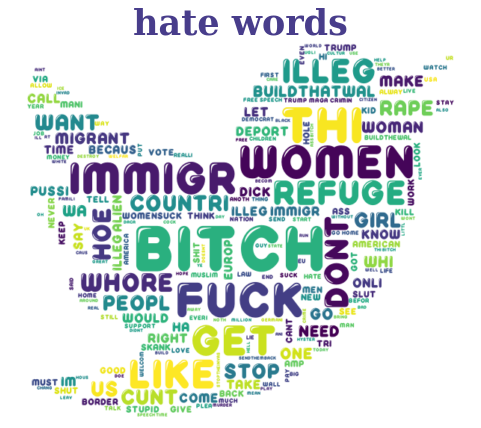

In [12]:
word_cloud('hate')

train = pd.DataFrame()
train['temp_list'] = train_cleaned['tweet'][train_cleaned['tag']==0].apply(lambda x:str(x).split())
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(10))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='viridis')

,Common_words,count
0,the,3209
1,to,2709
2,you,1886
3,and,1880
4,of,1826
5,in,1525
6,is,1142
7,immigr,1128
8,for,1097
9,are,892


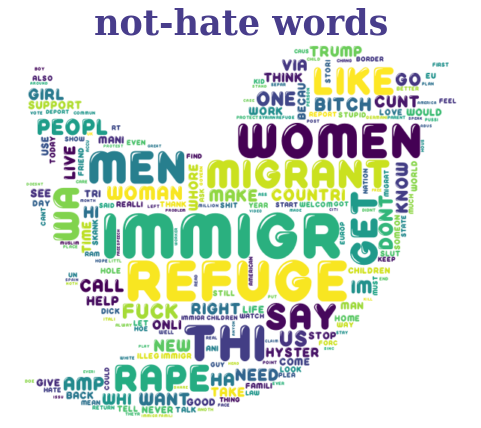

In [13]:
word_cloud('not-hate')

train = pd.DataFrame()
train['temp_list'] = train_cleaned['tweet'][train_cleaned['tag']==0].apply(lambda x:str(x).split())
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(10))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='viridis')

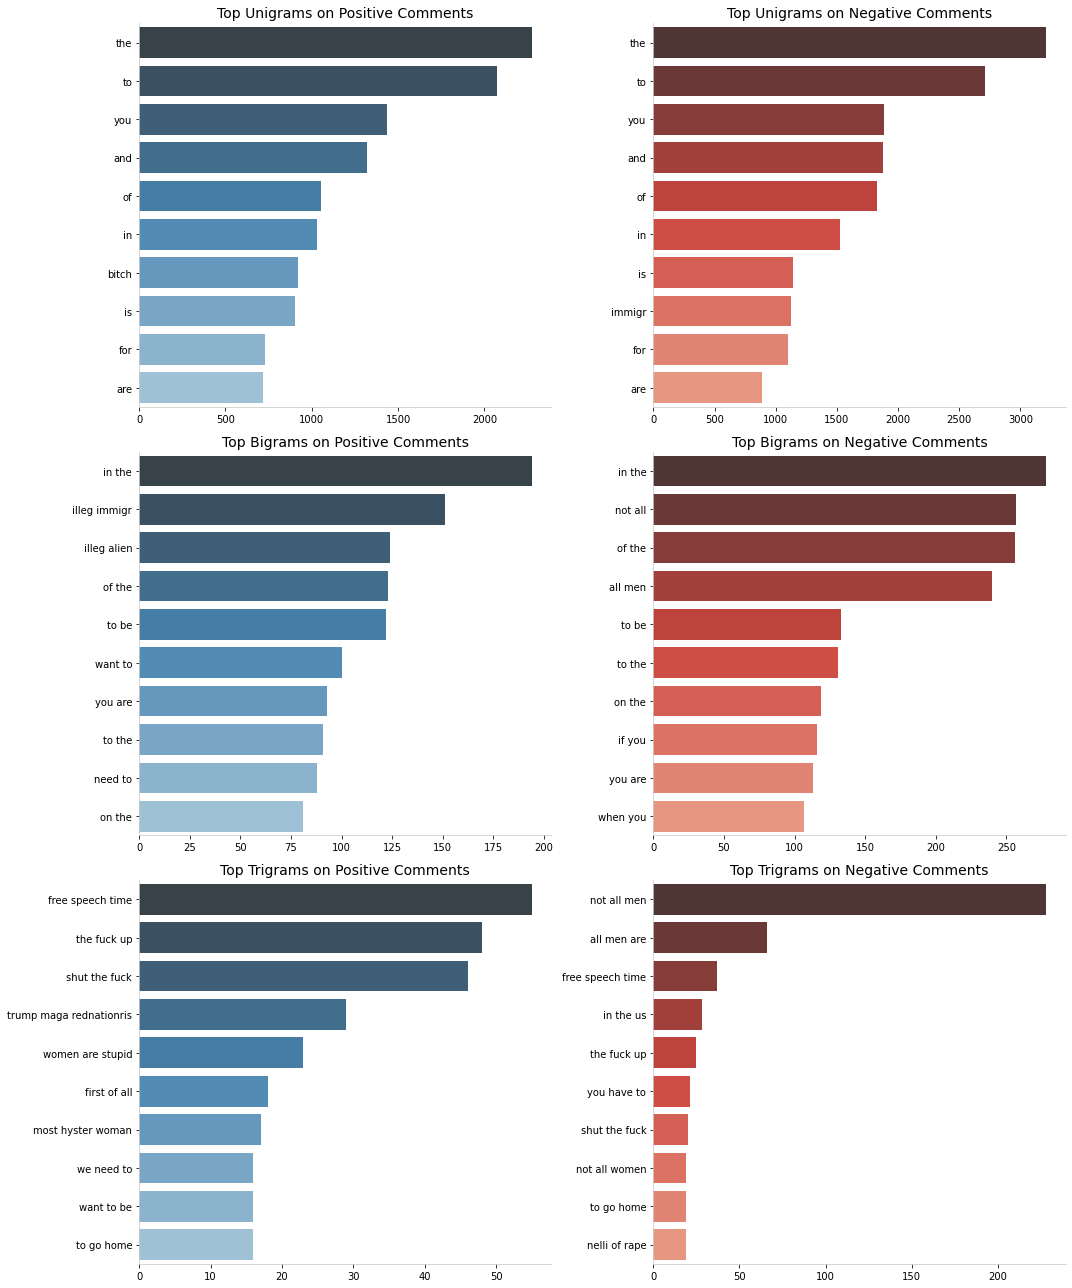

In [14]:
def ngrams_count(corpus, ngram_range, n=-1):
    """
    Args
    ----------
    corpus: text to be analysed [type: pd.DataFrame]
    ngram_range: type of n gram to be used on analysis [type: tuple]
    n: top limit of ngrams to be shown [type: int, default: -1]
    """
    
    # Using CountVectorizer to build a bag of words using the given corpus
    vectorizer = CountVectorizer( ngram_range=ngram_range).fit(corpus)
    bag_of_words = vectorizer.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    total_list = words_freq[:n]
    
    # Returning a DataFrame with the ngrams count
    count_df = pd.DataFrame(total_list, columns=['ngram', 'count'])
    return count_df

# Splitting the corpus into positive and negative comments
positive_comments = train_cleaned['tweet'][train_cleaned['class']=='hate']
negative_comments = train_cleaned['tweet'][train_cleaned['class']=='not-hate']

# Extracting the top 10 unigrams by sentiment
unigrams_pos = ngrams_count(positive_comments, (1, 1), 10)
unigrams_neg = ngrams_count(negative_comments, (1, 1), 10)


# Extracting the top 10 unigrams by sentiment
bigrams_pos = ngrams_count(positive_comments, (2, 2), 10)
bigrams_neg = ngrams_count(negative_comments, (2, 2), 10)



# Extracting the top 10 unigrams by sentiment
trigrams_pos = ngrams_count(positive_comments, (3, 3), 10)
trigrams_neg = ngrams_count(negative_comments, (3, 3), 10)



# Joining everything in a python dictionary to make the plots easier
ngram_dict_plot = {
    'Top Unigrams on Positive Comments': unigrams_pos,
    'Top Unigrams on Negative Comments': unigrams_neg,
    'Top Bigrams on Positive Comments': bigrams_pos,
    'Top Bigrams on Negative Comments': bigrams_neg,
    'Top Trigrams on Positive Comments': trigrams_pos,
    'Top Trigrams on Negative Comments': trigrams_neg,
}

# Plotting the ngrams analysis
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 18))
i, j = 0, 0
colors = ['Blues_d', 'Reds_d','Greens_d']
for title, ngram_data in ngram_dict_plot.items():
    ax = axs[i, j]
    sns.barplot(x='count', y='ngram', data=ngram_data, ax=ax, palette=colors[j])
    
    # Customizing plots
    format_spines(ax, right_border=False)
    ax.set_title(title, size=14)
    ax.set_ylabel('')
    ax.set_xlabel('')
    
    # Incrementing the index
    j += 1
    if j == 2:
        j = 0
        i += 1

plt.tight_layout()
plt.show()

# OverSampling to handle imbalance train dataset

In [15]:
train_cleaned['tweet'].shape

(9000,)

In [16]:
from imblearn.over_sampling import RandomOverSampler

inputs = train_cleaned['tweet'].values.reshape(-1,1)
target = train_cleaned['tag']
smote = RandomOverSampler()
inputs, target = smote.fit_sample(inputs,target)

inputs = inputs.reshape(inputs.shape[0],)

In [17]:
inputs.shape

(10434,)

# Feature Extraction

# Bag of Words

In [18]:
def Bag_words(vect, x_train, y_train, validation, test, ngram):
    
    c = vect(ngram_range=(1,ngram))

    x_train = c.fit_transform(inputs)
    shape = x_train.shape 
    if ngram==1:
        print('Train size with Unigram:',shape)
    elif ngram ==2:
        print('Train size with Bigram:',shape)
    elif ngram ==3:
        print('Train size with Trigram:',shape)
        
    val_train = c.transform(validation['tweet'].values)
    test_train = c.transform(test['tweet'].values)
    LR= LogisticRegression(max_iter=500)  
    LR.fit(x_train,target)
    val_pred = LR.predict(val_train)
    print('F1 Score on Validation Data -->',f1_score(validation['tag'],val_pred,average='macro'))
    
    test_pred = LR.predict(test_train)
    print('F1 Score on Test Data       -->',f1_score(test['tag'],test_pred,average='macro'),'\n')

#  CountVectorizer

In [19]:
for i in range(1,4):
    Bag_words(CountVectorizer,inputs,target,val_cleaned,test_cleaned,i)

Train size with Unigram: (10434, 14019)
F1 Score on Validation Data --> 0.6971926301970077
F1 Score on Test Data       --> 0.48746569573132625 

Train size with Bigram: (10434, 105098)
F1 Score on Validation Data --> 0.7216214479967451
F1 Score on Test Data       --> 0.4871146906950941 

Train size with Trigram: (10434, 242754)
F1 Score on Validation Data --> 0.719693094629156
F1 Score on Test Data       --> 0.48307776536992536 



In [20]:
for i in range(1,4):
    Bag_words(TfidfVectorizer,inputs,target,val_cleaned,test_cleaned,i)

Train size with Unigram: (10434, 14019)
F1 Score on Validation Data --> 0.7052361605338568
F1 Score on Test Data       --> 0.45550665491866216 

Train size with Bigram: (10434, 105098)
F1 Score on Validation Data --> 0.7046342286733858
F1 Score on Test Data       --> 0.41997826177677255 

Train size with Trigram: (10434, 242754)
F1 Score on Validation Data --> 0.7026762143974788
F1 Score on Test Data       --> 0.401742788039882 



# Word2Vec

In [21]:
def document_vector(doc):
    """Create document vectors by averaging word vectors. Remove out-of-vocabulary words."""
    doc = [word for word in doc if word in w2v.wv.vocab]
    if len(doc)==0:
        doc = ['th']
    return np.mean(w2v[doc], axis=0)

def Word_Vec(x_train,y_train, validation, test):
    
    x_train = pd.DataFrame(x_train)
    words_train = x_train[0].apply(word_tokenize)
    words_validation = validation['tweet'].apply(word_tokenize)
    words_test = test['tweet'].apply(word_tokenize)
    
    global w2v
    w2v = gensim.models.Word2Vec(words_train, size=350, window=10, min_count=1, iter=20)
    words_train = pd.DataFrame(words_train)
    words_validation = pd.DataFrame(words_validation)
    words_test = pd.DataFrame(words_test)

    x_train = list(words_train[0].apply(document_vector))
    x_val = list(words_validation['tweet'].apply(document_vector))
    x_test = list(words_test['tweet'].apply(document_vector))
    
    LR = LogisticRegression(C=500,multi_class='multinomial')
    LR.fit(x_train,y_train)
    
    val_pred = LR.predict(x_val)
    print('F1 Score on Validation Data -->',f1_score(validation['tag'],val_pred,average='macro'))

    test_pred = LR.predict(x_test)
    print('F1 Score on Test Data       -->',f1_score(test['tag'],test_pred,average='macro'),'\n')

In [22]:
print('*******WORD2VEC********')
Word_Vec(inputs, target, val_cleaned,test_cleaned)

*******WORD2VEC********
F1 Score on Validation Data --> 0.6901587301587302
F1 Score on Test Data       --> 0.43010868230381927 



# Matrix Factorization with Glove

In [23]:
def Glove(x_train, y_train, validation, test):
    
    x_train = glove.transform(x_train)
    x_val = glove.transform(validation['tweet'])
    x_test = glove.transform(test['tweet'])
    
    LR = LogisticRegression(max_iter=500) 
    LR.fit(x_train,y_train)
    val_pred = LR.predict(x_val)
    print('F1 Score on Validation Data -->',f1_score(validation['tag'],val_pred,average='macro'))

    test_pred = LR.predict(x_test)
    print('F1 Score on Test Data       -->',f1_score(test['tag'],test_pred,average='macro'),'\n')

In [24]:
glove = EmbeddingTransformer('glove')
print('******GLOVE******')
Glove(inputs,target,val_cleaned,test_cleaned)

******GLOVE******
F1 Score on Validation Data --> 0.6239657778119316
F1 Score on Test Data       --> 0.5406860398404582 

